In [1]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
from ngsolve import CoefficientFunction
from ngsolve.meshes import MakeStructured2DMesh
import time

Hier wird das gegebene Bild mit Hilfe der pickle library illustriert. Dabei belassen wir das Bild in der graustufen Darstellung.

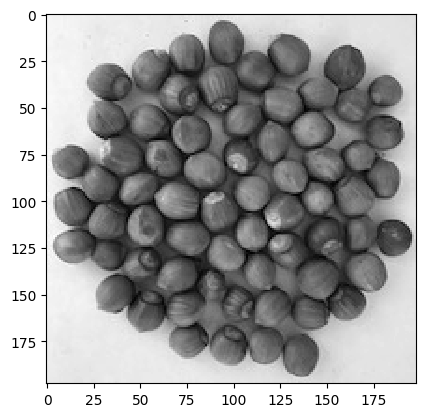

In [2]:
with open('img.pkl','rb') as fp:
    img = pickle.load(fp)
plt.imshow(img,interpolation='none', cmap='gray')


In [3]:
mesh = MakeStructured2DMesh(nx=int((img.shape[0]-1)/1),
                            ny=int((img.shape[1]-1)/1),
                            quads=False)
cfImg = VoxelCoefficient((0,0),(1,1),
                         img[np.arange(img.shape[0]-1,-1,-1)])

Hier wird das Problem illustriert, wobei noch keine Phasenseperation ersichtlich ist. Dies aus dem einfachen Grund, da das Funktional nocht nicht auf das Problem (Bild) angewandt wurde. 

In [4]:
Draw(cfImg,mesh,'cfImg')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [5]:
# Startwerte:
t0 = 0
dt0 = 0.1
tend = 3
eps0 = 1e-4
d2t = 0.02  #Änderungsrate für dt

# Initialisierung der Parameter
t = Parameter (t0)
dt = Parameter (dt0)
eps = Parameter (eps0)

In [6]:
# FEM Raum => Order = 2
V = H1(mesh, order=2)

# Trial Funktion
u = V.TrialFunction()
# Test Funktion 
v = V.TestFunction()

gfu = GridFunction(V)

a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)

a.AssembleLinearization(gfu.vec)

In [7]:
img_array = np.array(img)

In [8]:
print(np.min(img_array)) 
print(np.max(img_array))

-1.0
1.0


Das Bild enthält Werte zwischen -1 und 1, das ist ideal für diese Anwendung, weil die Pixel gem. Funktional W(u) aus der Aufgabenstellung in die Bereiche rund um -1, 0, oder 1 eingeteilt werden sollen.

Hier wird das gegebene Bild als Anfangswert der GridFunction definiert

In [9]:
gfu.Set(cfImg)

In [10]:
res = gfu.vec.CreateVector()
du = gfu.vec.CreateVector()

In [11]:
# GridFunction zu numpy array
gfu_array = gfu.vec.FV().NumPy()
gfu_array_t0 = gfu_array.copy()

In [12]:
# Newton Verfahren:
start_time = time.time()
for it in range(10000000):
    print("Newton iteration", it)

    # lösen des linearisierten Problems:
    # F(u_n)
    a.Apply (gfu.vec, res)

    # F'(u_n)
    a.AssembleLinearization(gfu.vec)

    du.data = a.mat.Inverse(V.FreeDofs()) * res

    # update gfu
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    # eps für nächsten Zeitschritt updaten
    eps.Set(eps.Get() * 1e-2)
    print("eps:", eps.Get())

    # Aktuelle Zeit updaten
    t.Set(t.Get()+dt.Get())
    print("Seconds passed: ", t.Get())

    # Abbruchkriterium: nach 2 Sekunden (wie in Aufgabenstellung beschrieben)
    t += dt.Get()
    print(t)
    if t >= tend:
        break

    # dt für nächsten Schritt updaten
    dt.Set(dt.Get() + d2t)
    print("dt für nächste Iteration: ", dt.Get())

    # Abbruchkriterium: wenn es vor schon vor Ablauf der 2 Sekunden konvergiert
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}A0.S = ", stopcritval)
    print(gfu)
    if stopcritval < 1e-13:
        break

end_time = time.time()
time_to_compute = end_time - start_time

Newton iteration 0
eps: 1.0000000000000002e-06
Seconds passed:  0.1
ParameterCF, val = 0.2

dt für nächste Iteration:  0.12000000000000001
<A u 0 , A u 0 >_{-1}A0.S =  0.22229593717973298
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 1
eps: 1.0000000000000002e-08
Seconds passed:  0.32
ParameterCF, val = 0.44

dt für nächste Iteration:  0.14
<A u 1 , A u 1 >_{-1}A0.S =  0.1215415671980145
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 2
eps: 1.0000000000000002e-10
Seconds passed:  0.5800000000000001
ParameterCF, val = 0.72

dt für nächste Iteration:  0.16
<A u 2 , A u 2 >_{-1}A0.S =  0.11885329825500877
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 3
eps: 1.0000000000000002e-12
Seconds passed:  0.8800000000000001
ParameterCF, val = 1.04

dt für nächste Iteration:  0.18
<A u 3 , A u 3 >_{-1}A0.S =  0.10865363445434742
gridfunction '

In [13]:
print(f"Gebrauchte Zeit, um das Newton Verfahren zu machen: {round(time_to_compute, 3)} Sekunden!")

Gebrauchte Zeit, um das Newton Verfahren zu machen: 7.883 Sekunden!


### Resultat mit änderndem dt und eps:
Die Phasentrennung ist immernoch klar erkennbar, jedoch wird weniger Rechenzeit benötigt und die "störende weisse Stelle" ist verschwunden.

In [14]:
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

Es sind nicht mehr alle Werte im Intervall [-1,1]. Dies sieht man auch in der Illustration oben. Jene "spikes" divergieren und können mit diesem setup an Konstanten nicht in die gewünschten Gebiete von -1, 0, ooder 1 gezogen werden.

In [15]:
# GridFunction in numpy array konvertieren
gfu_array_2s = gfu.vec.FV().NumPy()

# min und max der GridFunction printen
print(np.min(gfu_array_2s), np.max(gfu_array_2s))

-6.2199423920925785 8.720883132240614


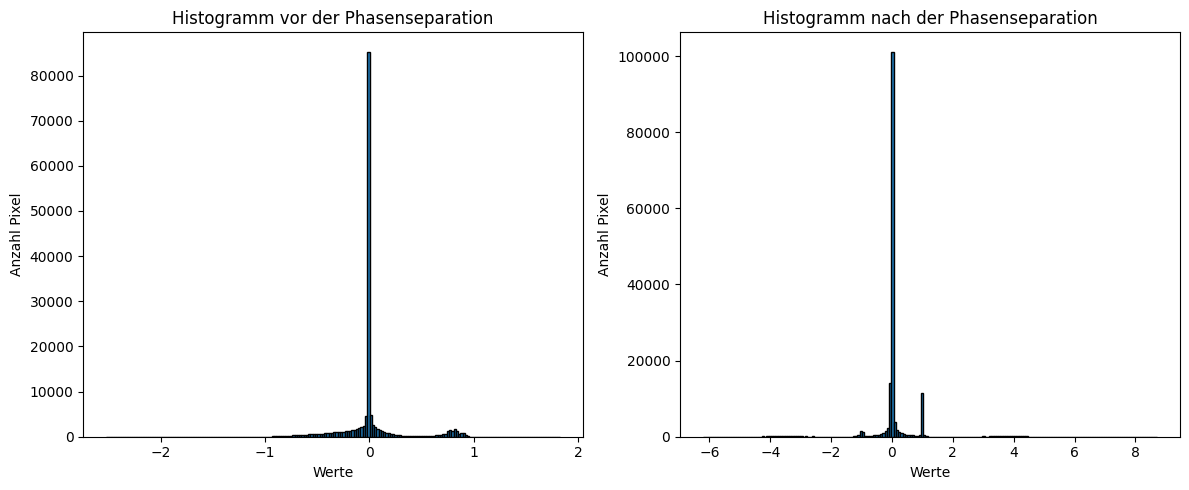

In [16]:
# Anzahl bins
num_bins = 200

# subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot des ersten Histogramms => vor der Phasenseparation
axs[0].hist(gfu_array_t0, bins=num_bins, edgecolor='black')
#axs[0].set_yscale('log')  # y-Achse logarithmisch => Phasenseparation besser ersichlich in linearer y-Achse
axs[0].set_title('Histogramm vor der Phasenseparation')
axs[0].set_xlabel('Werte')
axs[0].set_ylabel('Anzahl Pixel')

# Plot des zweiten Histogramms => nach der Phasenseparation
axs[1].hist(gfu_array_2s, bins=num_bins, edgecolor='black')
#axs[1].set_yscale('log')  # y-axis logarithmisch
axs[1].set_title('Histogramm nach der Phasenseparation')
axs[1].set_xlabel('Werte')
axs[1].set_ylabel('Anzahl Pixel')

plt.tight_layout()
plt.show()

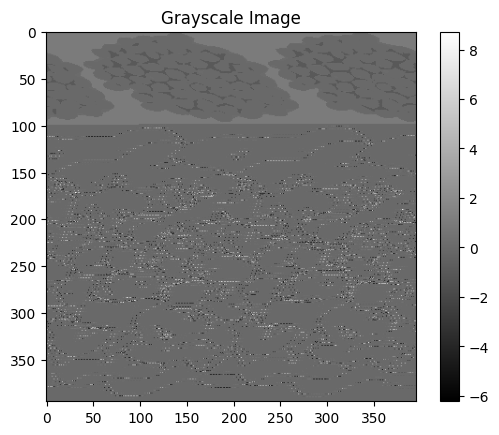

In [17]:
size = int(np.sqrt(len(gfu_array_2s)))
gfu_array_2s_reshaped = gfu_array_2s[:size**2].reshape((size, size))

plt.imshow(gfu_array_2s_reshaped, cmap='gray')
plt.colorbar()  # Optionally, you can add a colorbar to show intensity values
plt.title('Grayscale Image')
plt.show()

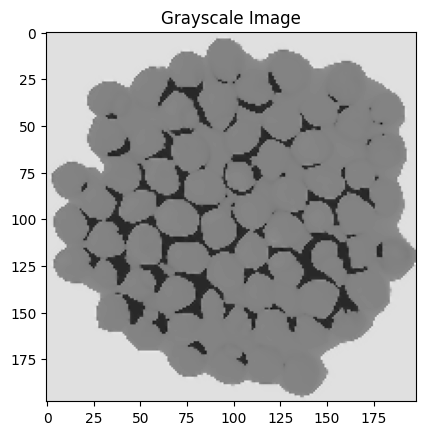

In [26]:
imgNew = np.array([[gfu(mesh(i/(img.shape[0]-1), 1-j/(img.shape[1]-1)))
                for i in range(img.shape[0])]
                for j in range(img.shape[0])]) 



plt.imshow(imgNew, cmap='gray')
plt.title('Grayscale Image')
plt.show()